Import all required python modules.

In [1]:
import cf_units
import cftime

In [2]:
import iris
import ncdata
import numpy as np
import xarray as xr

In [3]:
from pathlib import Path

In [4]:
import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [5]:
from ncdata.iris_xarray import cubes_to_xarray, cubes_from_xarray

In [6]:
iris.FUTURE.date_microseconds = True

In [7]:
iris.FUTURE.save_split_attrs = True

Load the grid mask data to use to regrid the ozone data.

In [8]:
esm_grid_mask_filepath = Path('/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/grids/global.N96/2020.05.19/qrparm.mask')

In [9]:
grid_cube = iris.load_cube(esm_grid_mask_filepath)
grid_cube.coord("latitude").guess_bounds()
grid_cube.coord("longitude").guess_bounds()

In [10]:
lat_points = grid_cube.coord("latitude").points
lon_points = grid_cube.coord("longitude").points

In [11]:
grid_coords = [("latitude", lat_points), ("longitude", lon_points)]

Load the ozone forcing data.

In [12]:
cmip6_pi_ozone_filepath = Path('/g/data/qv56/replicas/input4MIPs/CMIP6/CMIP/UReading/UReading-CCMI-1-0/atmos/monC/vmro3/gn/v20160830/vmro3_input4MIPs_ozone_CMIP_UReading-CCMI-1-0_gn_185001-185012.nc')

In [13]:
orig_ozone_cube = iris.load_cube(cmip6_pi_ozone_filepath)

Fix the time units. "months since" makes sense for calendar="360_day".

In [14]:
months_since_1850_units = cf_units.Unit('months since 1850-01-01 00:00', calendar='360_day')

In [15]:
time_coord_dim = orig_ozone_cube.coord_dims('time')

In [16]:
new_time_coord = iris.coords.DimCoord(
    orig_ozone_cube.coord('time').points,
    standard_name='time',
    units=months_since_1850_units
)

In [17]:
orig_ozone_cube.remove_coord('time')
orig_ozone_cube.add_dim_coord(new_time_coord, time_coord_dim)

Change the pressure units from hPa to Pa to match the available pressure data.

In [18]:
orig_ozone_cube.coord('air_pressure').convert_units('Pa')

Select one month of data: December 1850, to match the one month of available pressure data.

In [19]:
nov = cftime.Datetime360Day(1850, 11, 30)

In [20]:
dec = iris.Constraint(time=lambda cell: cell.point > nov)

In [21]:
dec_ozone_cube = orig_ozone_cube.extract(dec)

In [22]:
dec_ozone_cube.remove_coord('time')

Interpolate the December ozone cube to the grid coordinates used by ESM1.6.

In [23]:
ozone_cube = dec_ozone_cube.interpolate(grid_coords, iris.analysis.Linear())

In [24]:
ozone_cube

<iris 'Cube' of mole_fraction_of_ozone_in_air / (mole mole-1) (air_pressure: 66; latitude: 145; longitude: 192)>

Plot the ozone data at each pressure level

In [25]:
ozone_cube_pressures = ozone_cube.coord('air_pressure').points

In [26]:
pressure_constraint = lambda level: iris.Constraint(air_pressure=ozone_cube_pressures[level])

In [27]:
cube_at_level = lambda level: ozone_cube.extract(pressure_constraint(level))

level: 1, air pressure: 92500.0


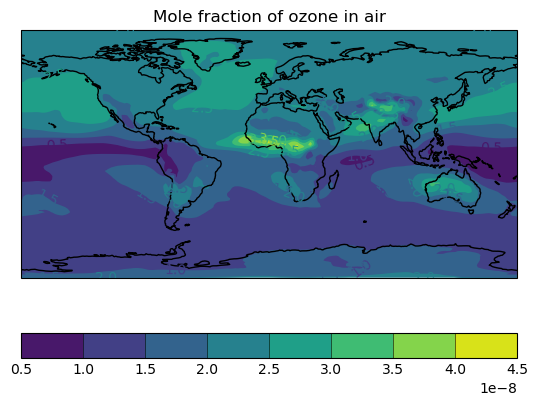

level: 2, air pressure: 85000.0


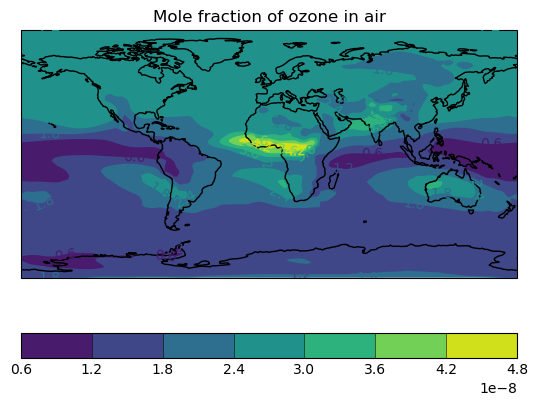

level: 3, air pressure: 80000.0


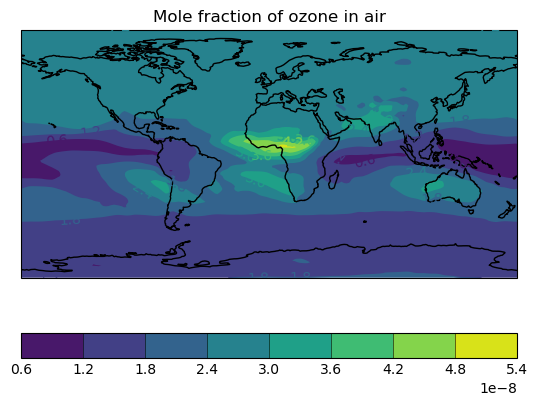

level: 4, air pressure: 78000.0


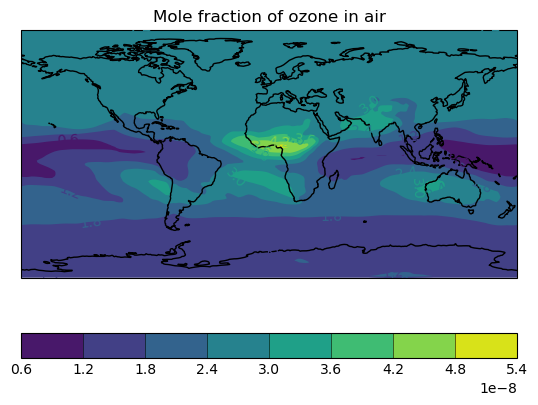

level: 5, air pressure: 75000.0


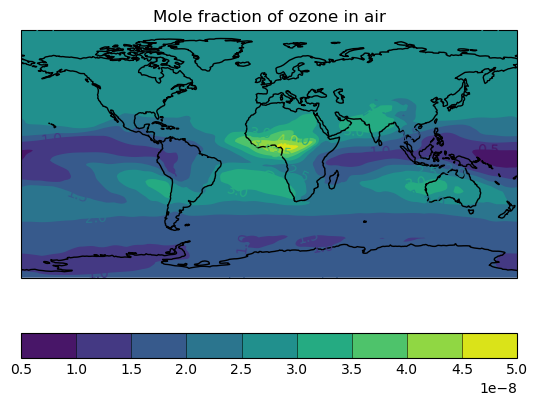

level: 6, air pressure: 70000.0


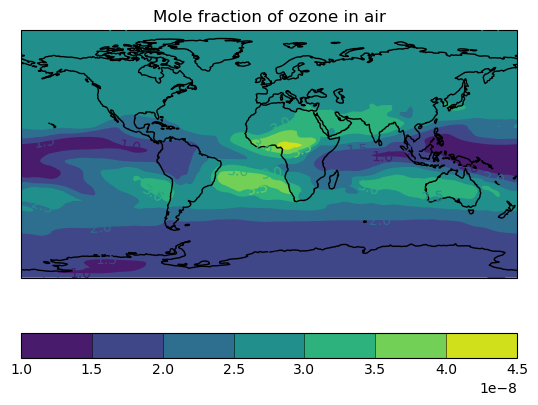

level: 7, air pressure: 65000.0


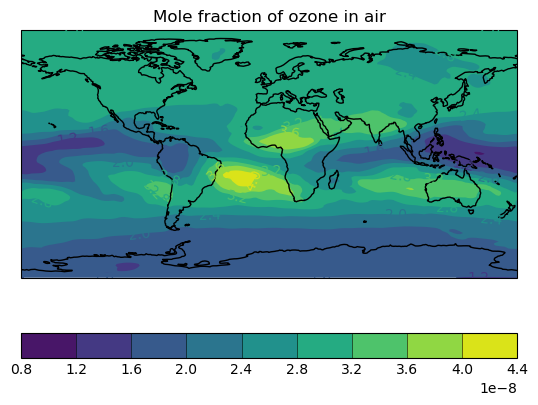

level: 8, air pressure: 60000.0


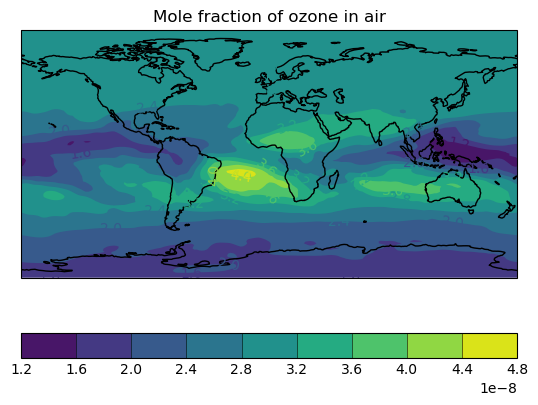

level: 9, air pressure: 50000.0


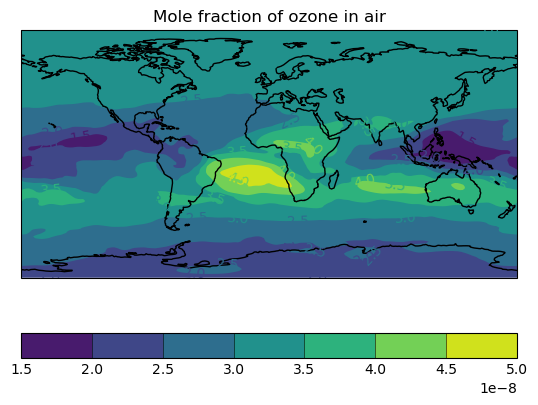

level: 10, air pressure: 45000.0


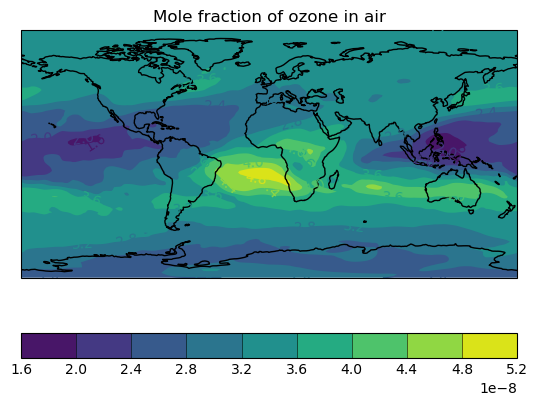

level: 11, air pressure: 40000.0


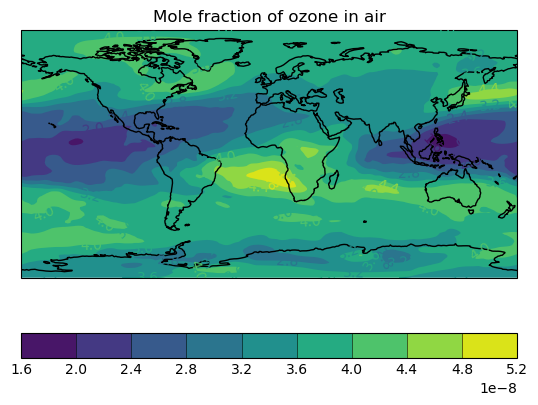

level: 12, air pressure: 35000.0


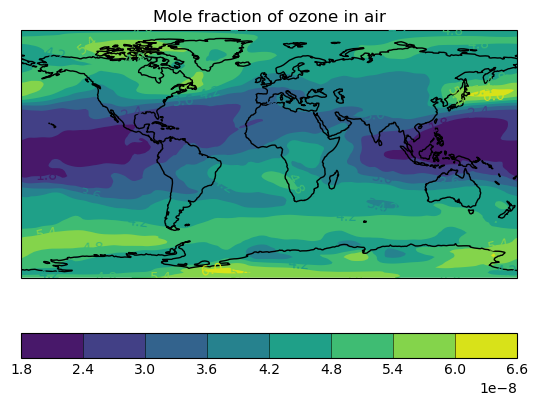

level: 13, air pressure: 30000.0


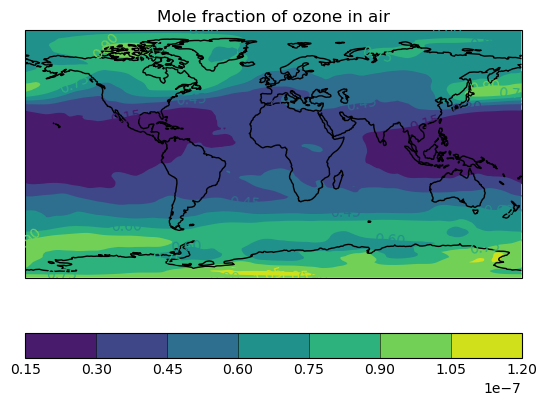

level: 14, air pressure: 28500.0


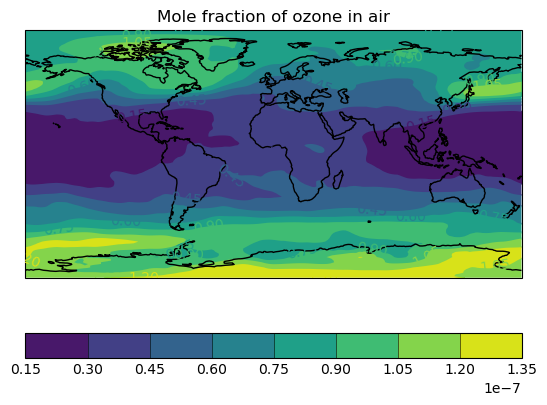

level: 15, air pressure: 25000.0


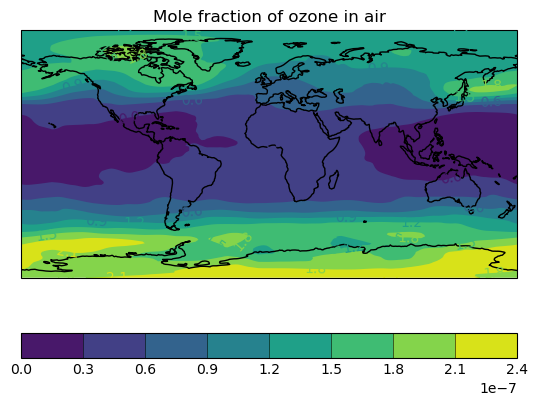

level: 16, air pressure: 20000.0


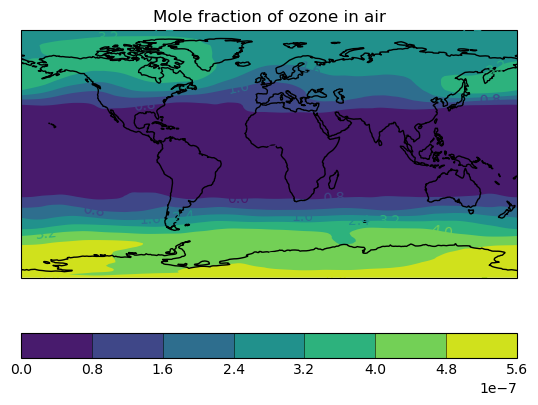

level: 17, air pressure: 17000.0


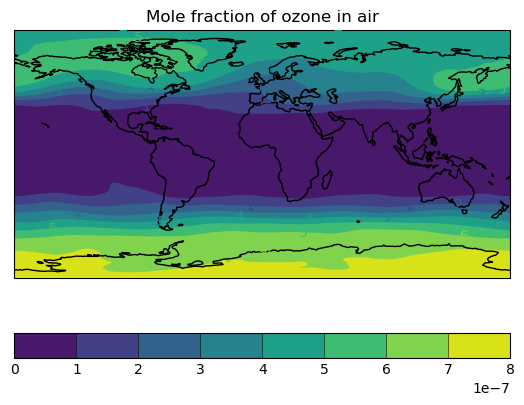

level: 18, air pressure: 15000.0


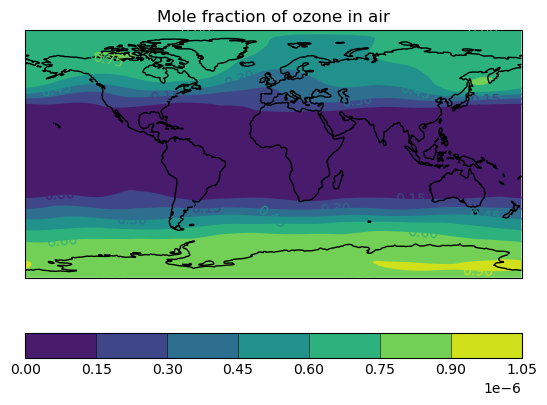

level: 19, air pressure: 13000.0


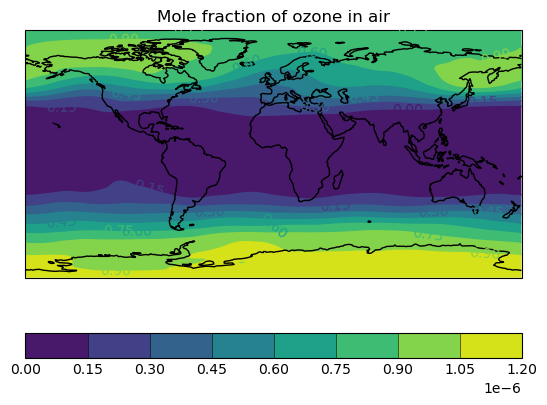

level: 20, air pressure: 11500.0


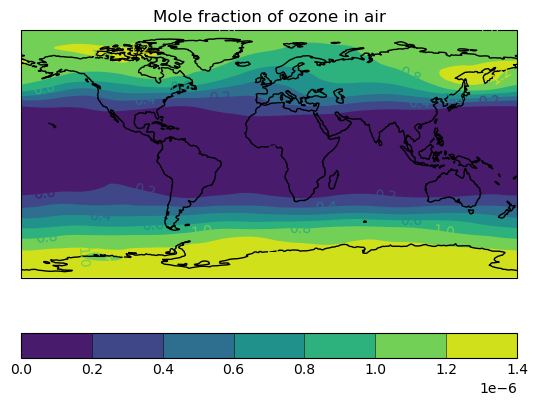

level: 21, air pressure: 10000.0


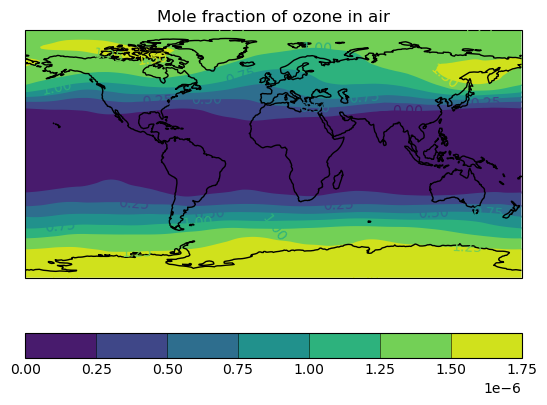

level: 22, air pressure: 9000.0


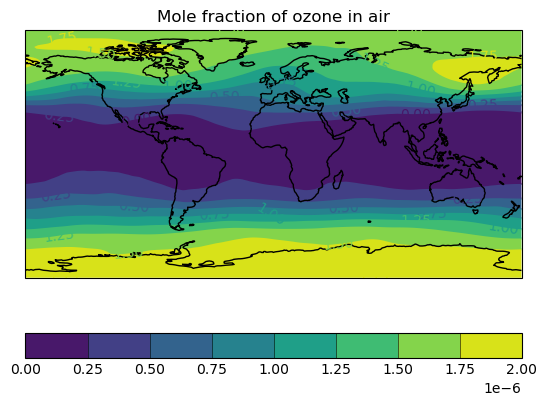

level: 23, air pressure: 8000.0


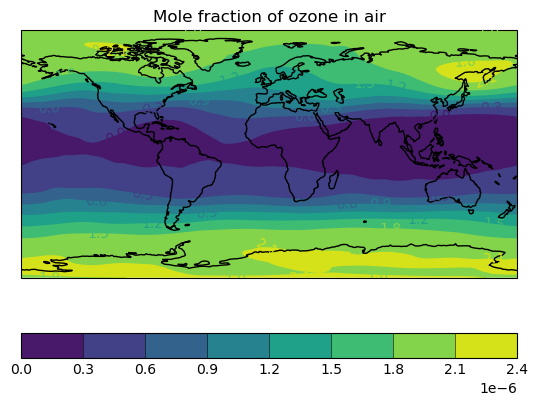

level: 24, air pressure: 7000.0


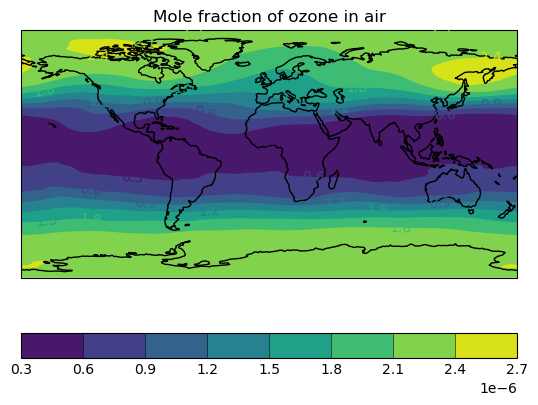

level: 25, air pressure: 6000.0


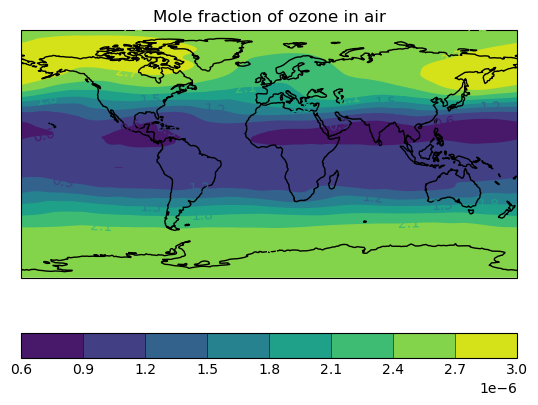

level: 26, air pressure: 5000.0


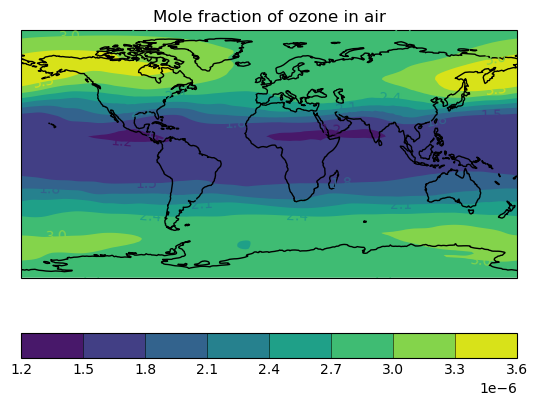

level: 27, air pressure: 4000.0


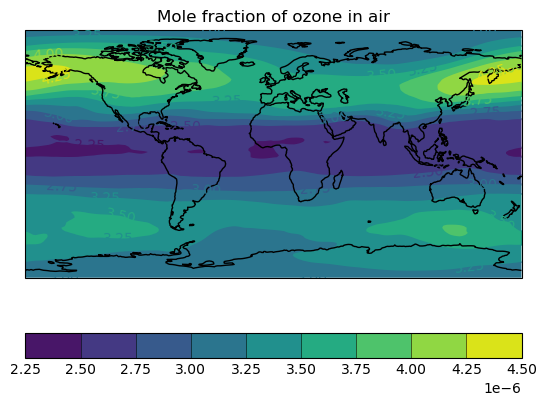

level: 28, air pressure: 3500.0


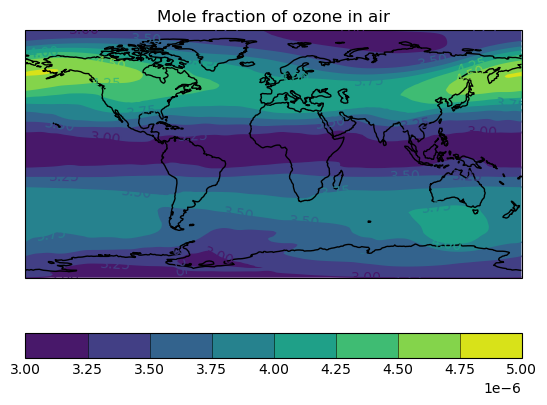

level: 29, air pressure: 3000.0


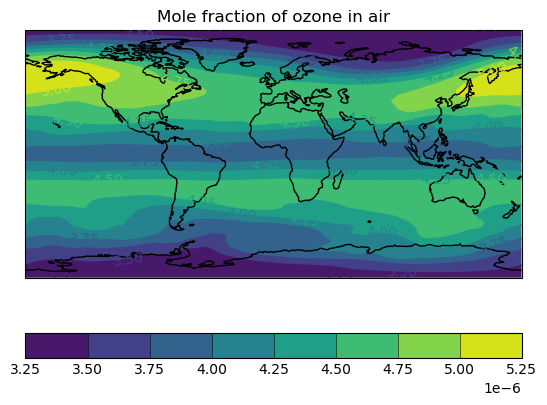

level: 30, air pressure: 2500.0


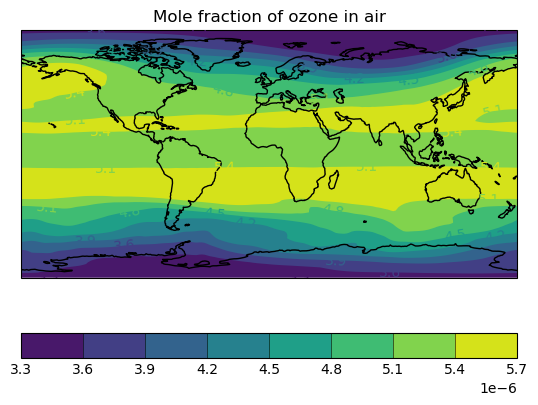

level: 31, air pressure: 2000.0


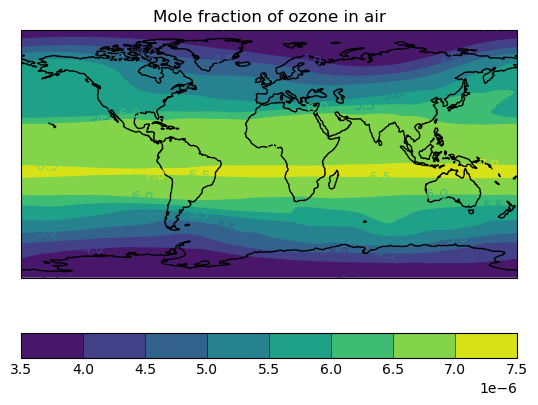

level: 32, air pressure: 1500.0


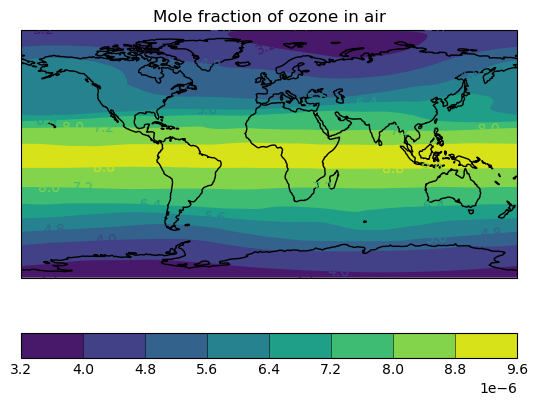

level: 33, air pressure: 1000.0


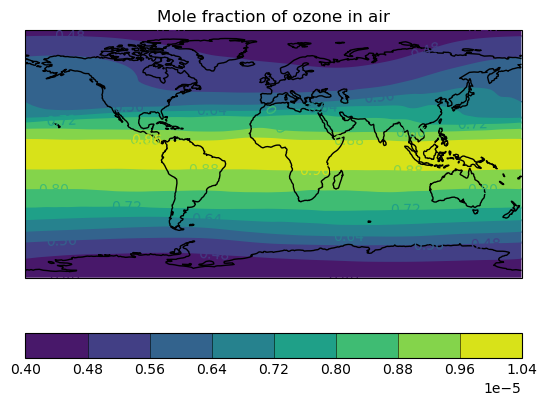

level: 34, air pressure: 700.0


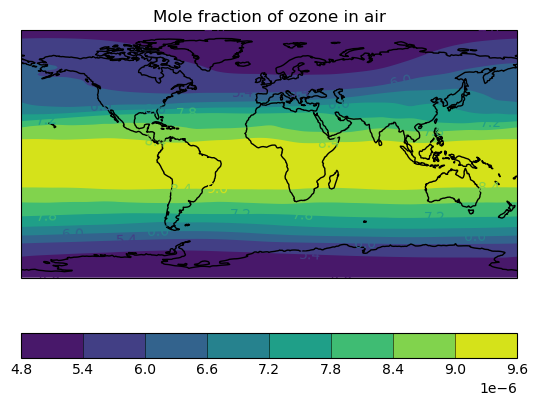

level: 35, air pressure: 500.0


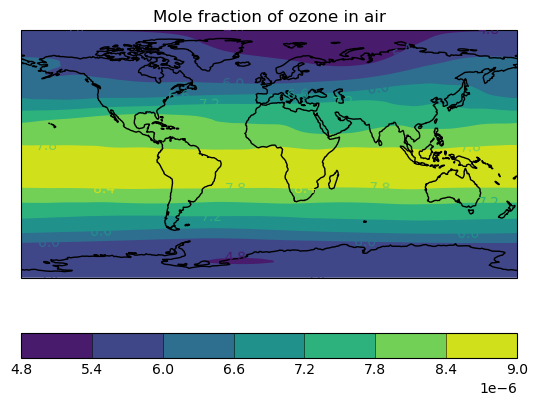

level: 36, air pressure: 400.0


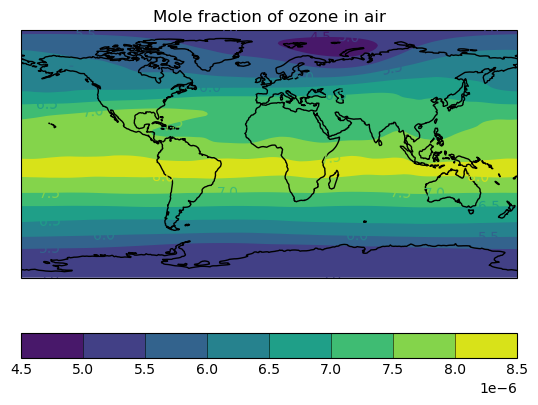

level: 37, air pressure: 300.0


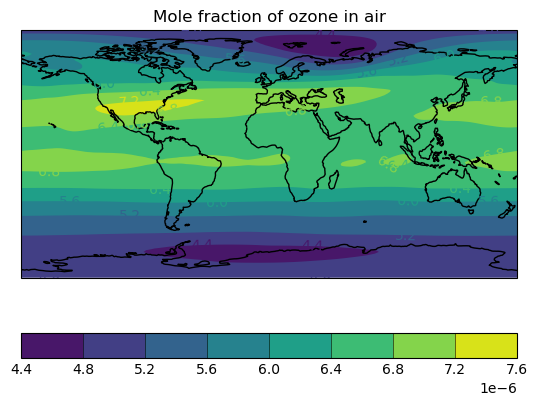

level: 38, air pressure: 200.0


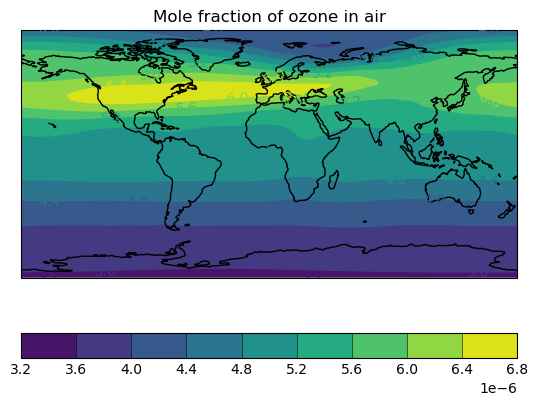

level: 39, air pressure: 150.0


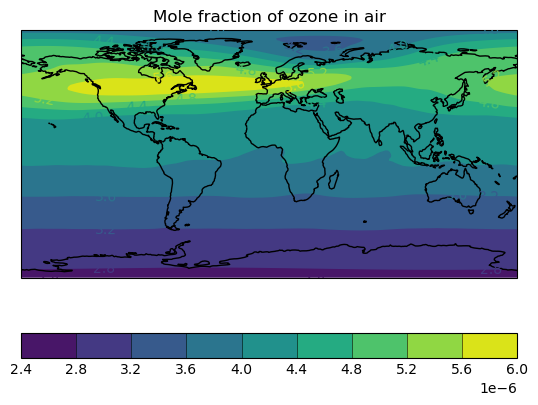

level: 40, air pressure: 100.0


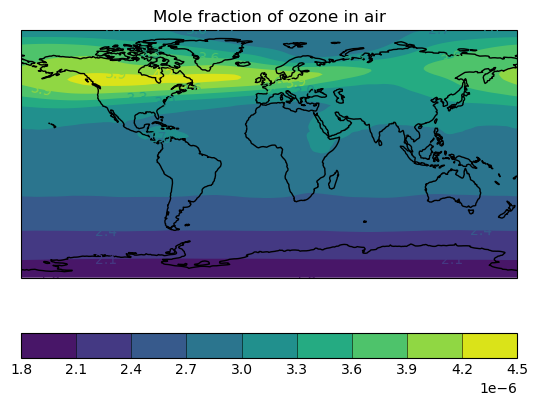

level: 41, air pressure: 70.0


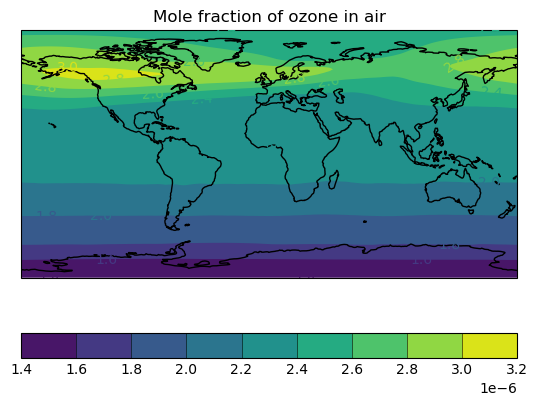

level: 42, air pressure: 50.0


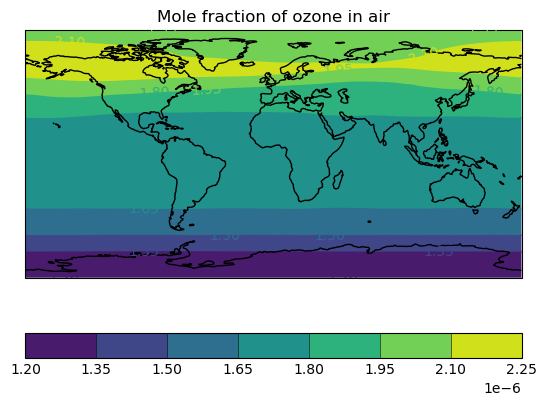

level: 43, air pressure: 40.0


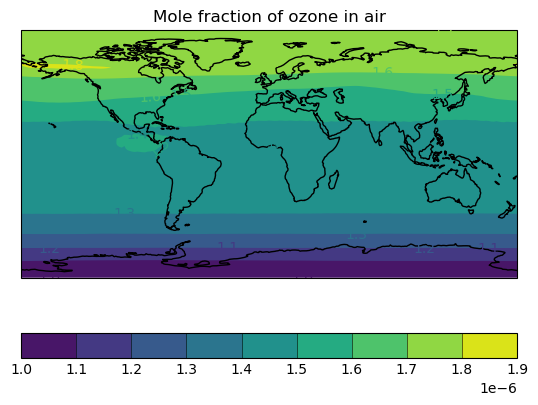

level: 44, air pressure: 30.000001907348633


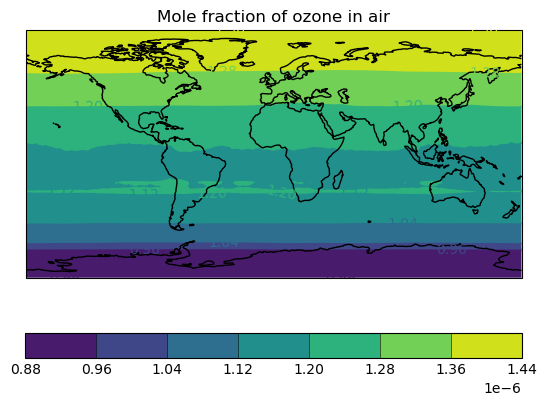

level: 45, air pressure: 20.0


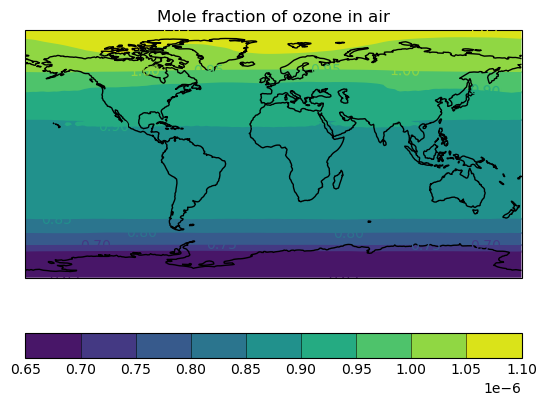

level: 46, air pressure: 15.000000953674316


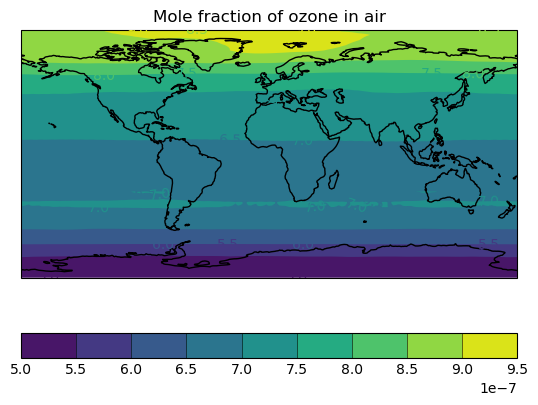

level: 47, air pressure: 10.0


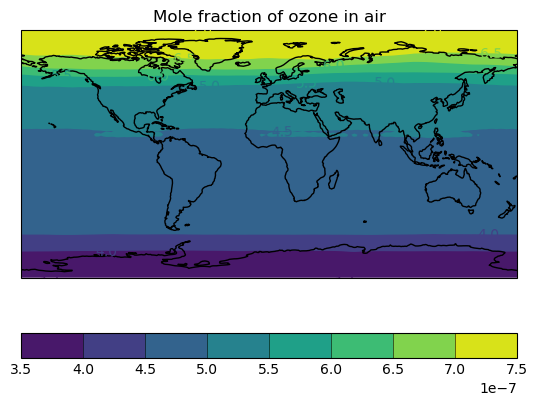

level: 48, air pressure: 7.0


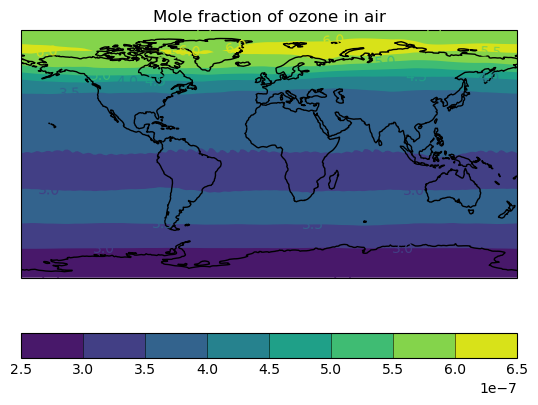

level: 49, air pressure: 5.0


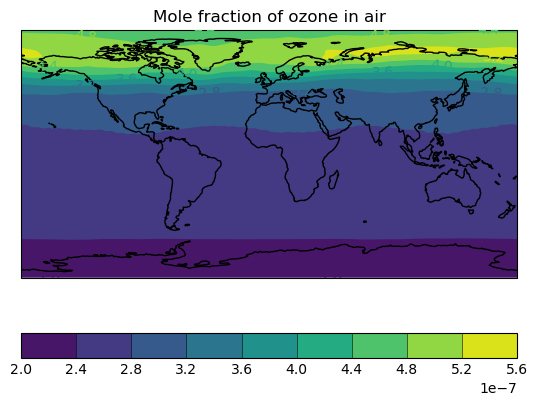

level: 50, air pressure: 4.0


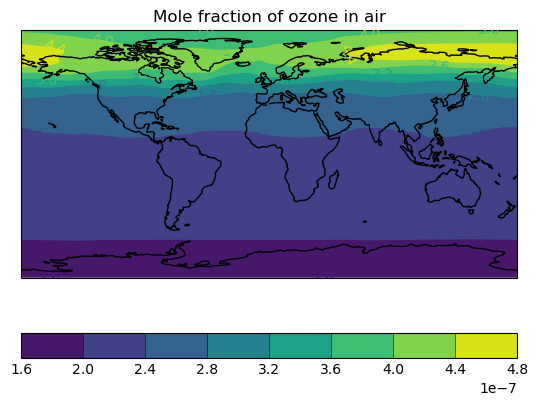

level: 51, air pressure: 3.0


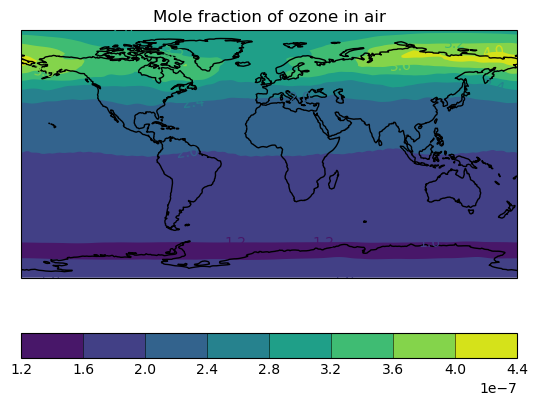

level: 52, air pressure: 2.0


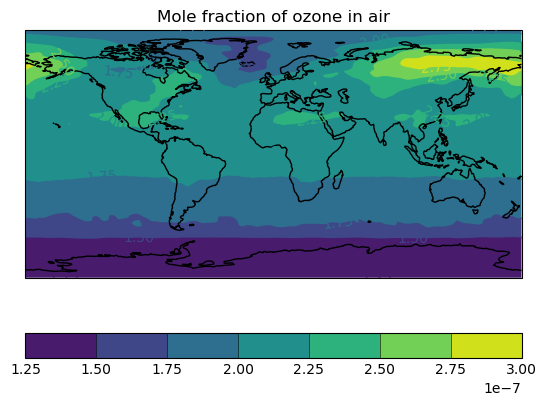

level: 53, air pressure: 1.5


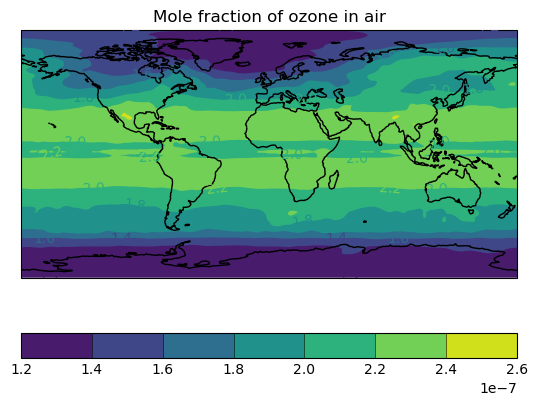

level: 54, air pressure: 1.0


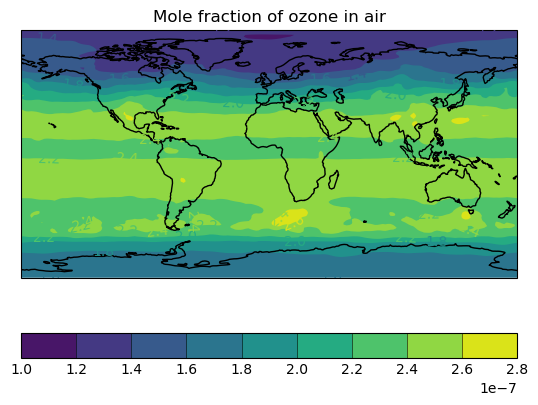

level: 55, air pressure: 0.7000000476837158


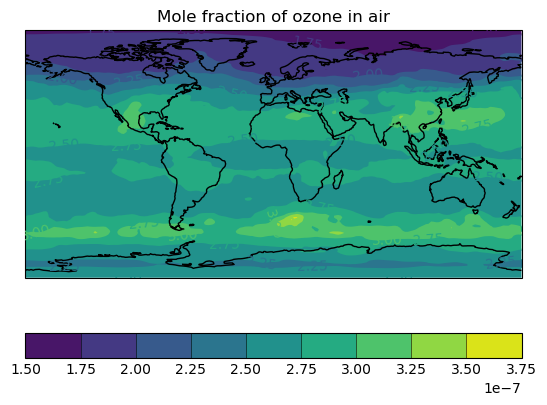

level: 56, air pressure: 0.5


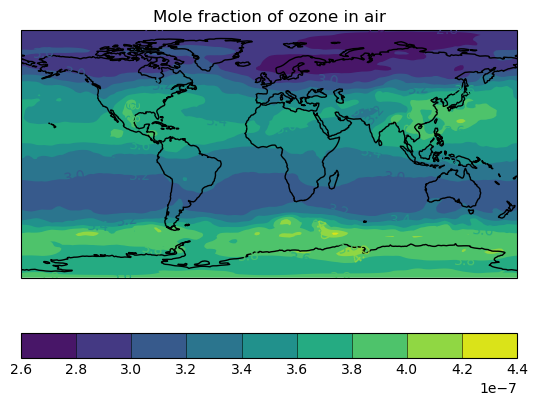

level: 57, air pressure: 0.4000000059604645


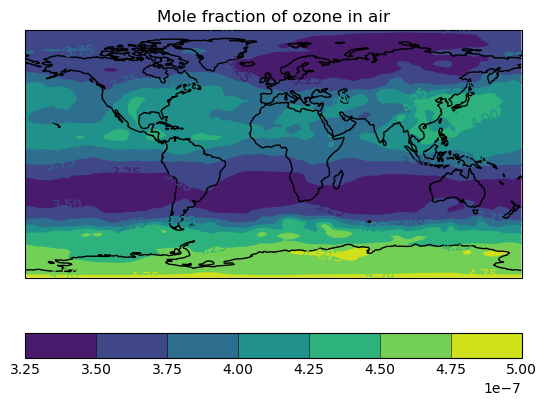

level: 58, air pressure: 0.30000001192092896


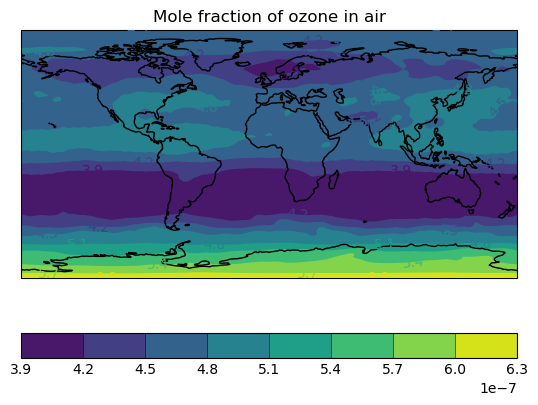

level: 59, air pressure: 0.20000000298023224


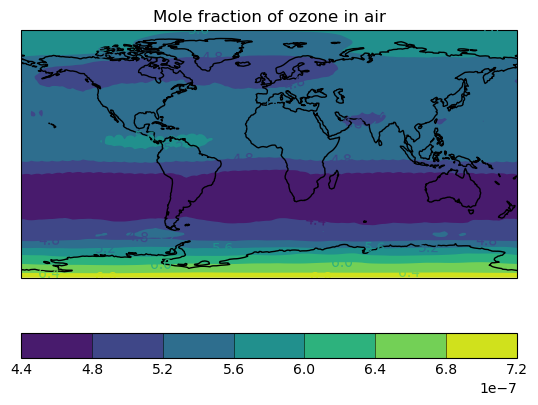

level: 60, air pressure: 0.15000000596046448


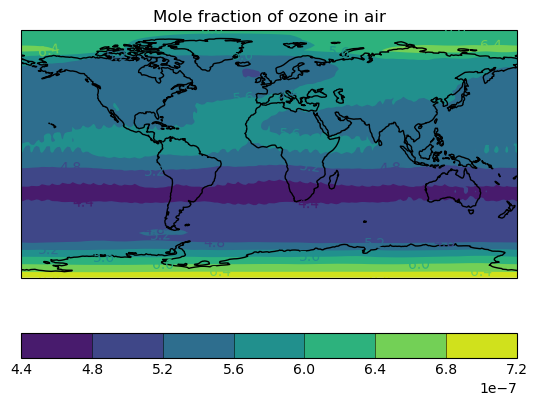

level: 61, air pressure: 0.10000000149011612


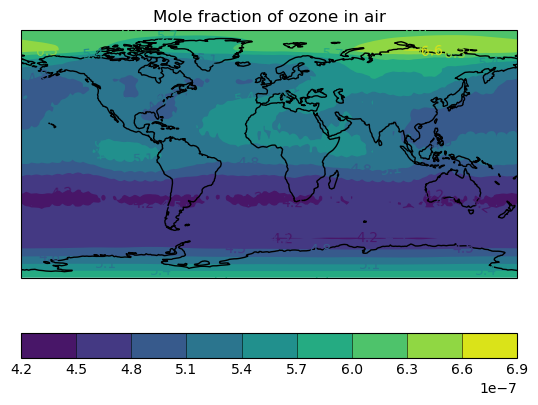

level: 62, air pressure: 0.07999999821186066


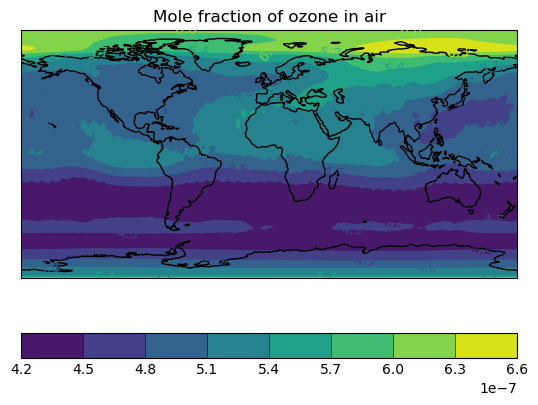

level: 63, air pressure: 0.05000000074505806


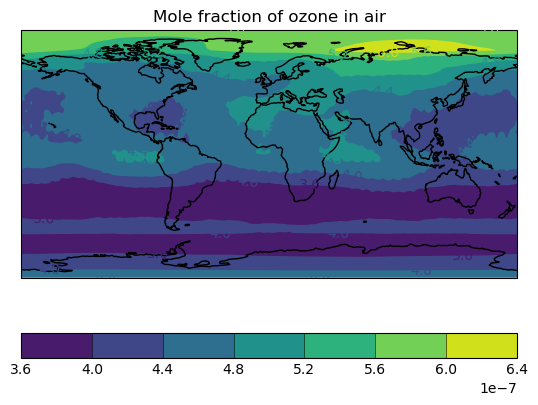

level: 64, air pressure: 0.030000001192092896


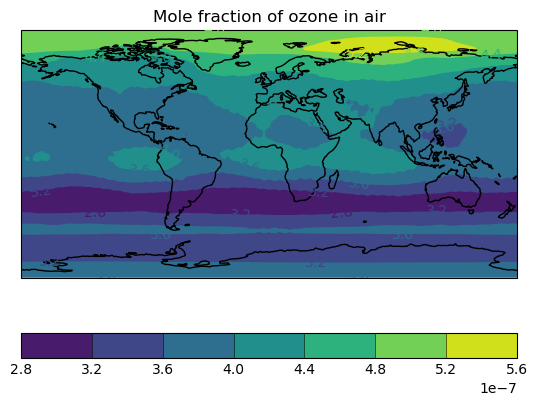

level: 65, air pressure: 0.009999999776482582


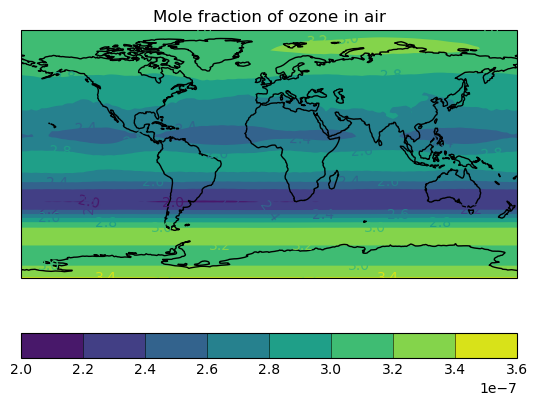

IndexError: index 66 is out of bounds for axis 0 with size 66

In [28]:
for n in range(len(ozone_cube_pressures)):
    level = n+1
    pressure = cube_at_level(level).coord('air_pressure').points[0]
    print(f'level: {level}, air pressure: {pressure}')
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(level))

    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)

    plt.show()

Convert the ozone cube to an XArray DataSet

In [ ]:
ozone_ds = cubes_to_xarray(ozone_cube)

Rename the air pressure coordinate to 'air_pressure'

In [ ]:
ozone_ds = ozone_ds.rename({'plev': 'air_pressure'})

Obtain the pressure data from a spinup file for December 2091.

In [ ]:
spinup_filepath = Path('/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/June2025/output999/atmosphere/netCDF/aiihca.pa-209112_mon.nc')

In [ ]:
spinup_cube = iris.load(spinup_filepath)

In [ ]:
pressure_index = 94

In [ ]:
pressure_cube = spinup_cube[pressure_index]

Remove the time coordinate because only one month's data is being used.

In [ ]:
pressure_cube

In [ ]:
pressure_cube.remove_coord('time')

Convert the pressure cube to an XArray Dataset

In [ ]:
pressure_ds = cubes_to_xarray(pressure_cube).squeeze()

In [ ]:
pressure_ds

Identify the ozone concentration variable

In [ ]:
ozone_var='vmro3'

The target 'lat' and 'lon' values are the existing coordinates in pressure_ds.

In [ ]:
target_lat = pressure_ds['lat']
target_lon = pressure_ds['lon']

The target 'air_pressure' values are the 'fld_s00i407' Data Variable in pressure_ds, temporarily renamed to 'air_pressure'

In [ ]:
target_pressure = pressure_ds['fld_s00i407'].rename('air_pressure')

Use the kwargs syntax for unstructured interpolation

In [ ]:
target_points = {
    'lat': target_lat,
    'lon': target_lon,
    'air_pressure': target_pressure
}

Perform the interpolation

In [ ]:
ozone_at_level = ozone_ds[ozone_var].interp(
    **target_points,
    method='linear' 
)

In [ ]:
ozone_at_level

Merge the results

In [ ]:
ozone_at_level_ds = pressure_ds.merge(ozone_at_level)

In [ ]:
ozone_at_level_cubelist = cubes_from_xarray(ozone_at_level_ds)

In [ ]:
ozone_at_level_cubelist

In [ ]:
ozone_constraint = standard_name='mole_fraction_of_ozone_in_air'

In [ ]:
ozone_ancil_cube = ozone_at_level_cubelist.extract_cube(ozone_constraint)

In [ ]:
ozone_ancil_cube

In [ ]:
level_constraint = lambda level: iris.Constraint(model_level_number=level)

In [ ]:
cube_at_level = lambda level: ozone_ancil_cube.extract(level_constraint(level))

In [ ]:
for n in range(38):
    level = n+1
    height = cube_at_level(level).coord('atmosphere_hybrid_height_coordinate').points[0]
    print(f'model_level_number: {level}, hybrid_height: {height:.5g}', )
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(level))

    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)

    plt.show()